In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from prettytable import PrettyTable, TableStyle

# Data Analysis Begins

- Load data

In [2]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    if option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    return df

tentative_df = load_data()
tentative_df

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,adj_prison_budget,median_house_value,house_affordability,Category,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate
0,Alameda,1985,1185500,0.009809,0.466890,1606.368564,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
1,Alameda,1986,1206900,0.010353,0.445778,1635.365854,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
2,Alameda,1987,1220600,0.009588,0.538580,1653.929539,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
3,Alameda,1988,1242300,0.008825,0.520660,1683.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
4,Alameda,1989,1261200,0.008375,0.497018,1708.943089,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,Yuba,2019,79619,0.004095,0.411043,126.379365,6.2,201.708250,15.2,41.5,...,1.290150,257100.0,4.541841,Rural,0,1,0,0,0.072427,82.3
2258,Yuba,2020,81178,0.004977,0.398515,128.853968,10.6,197.248655,16.3,37.5,...,1.278197,273600.0,4.861580,Rural,0,1,0,0,0.071218,82.2
2259,Yuba,2021,82091,0.004312,0.420904,130.303175,8.4,204.337343,15.6,39.3,...,1.338206,286000.0,4.706734,Rural,0,1,0,0,0.070699,81.2
2260,Yuba,2022,82563,0.003379,0.433692,131.052381,5.6,199.314588,14.9,39.5,...,1.309347,350600.0,5.510326,Rural,0,1,0,0,0.069229,82.7


### Load and view data

#### New features, excluding the previous crime

In [3]:
tentative_df["renter_ratio"]=tentative_df['Total_Persons_Renter']/tentative_df['Total_Persons']
tentative_df["social_vs_security"]=(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])/(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])
tentative_df["security_vs_social"]=(tentative_df['adj_police_budget']+tentative_df['adj_judiciary_budget']+tentative_df['adj_prison_budget'])/(tentative_df['adj_education_budget']+tentative_df['adj_welfare_budget']+tentative_df['adj_health_budget'])

In [4]:
feature_0=['Population','clearance_rate','population_density', 'unemployment_rate', 'adjusted_income','poverty_rate', 'rent_burden', 
       'home_ownership_rate','mobile_home_ratio', 'vacancy_rate', "renter_ratio", 'Number_of_Persons_per_HseHld','median_age',
       'adj_police_budget','adj_education_budget', 'adj_welfare_budget','adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability', 'uninsured_rate','high_school_rate', "social_vs_security", "security_vs_social"]
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']
crime_dataframe=tentative_df[['County', 'Year',  'crime_rate']+feature_0+feature_cat]
crime_dataframe=crime_dataframe.set_index(['County', 'Year'])
crime_dataframe.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985                NaN              NaN           NaN          NaN   
        1986                NaN              NaN           NaN          NaN   
        1987                NaN              NaN           NaN          NaN   
        1988                NaN              NaN           NaN          NaN   
        1989                NaN              NaN           NaN          NaN   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985                  NaN                NaN  ...   
        1986                  NaN                NaN  ...   
        1987                  NaN                NaN  ...   
        1988                  NaN                NaN  ...   
        1989                  NaN                NaN  ...   

              adj_judiciary_budget  adj_prison_budget  house_affordability  \
County  Year                                                                 
Alameda 1985                   NaN                NaN                  NaN   
        1986                   NaN                NaN                  NaN   
        1987                   NaN                NaN                  NaN   
        1988                   NaN                NaN                  NaN   
        1989                   NaN                NaN                  NaN   

              uninsured_rate  high_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985             NaN               NaN                 NaN   
        1986             NaN               NaN                 NaN   
        1987             NaN               NaN                 NaN   
        1988             NaN               NaN                 NaN   
        1989             NaN               NaN                 NaN   

              security_vs_social  Category_Rural  Category_Suburban  \
County  Year                                                          
Alameda 1985                 NaN               0                  0   
        1986                 NaN               0                  0   
        1987                 NaN               0                  0   
        1988                 NaN               0                  0   
        1989                 NaN               0                  0   

              Category_Urban  
County  Year                  
Alameda 1985               1  
        1986               1  
        1987               1  
        1988               1  
        1989               1  

[5 rows x 30 columns]

Impute Missing Values as follows:
1) For each feature, once we fix the County, the the feature becomes a time series from 1985 to 2023 with some missing values.
2) We apply simple linear regression of Year vs feature to impute the missing values

In [5]:


# 1. Copy your original DataFrame and set a MultiIndex
df = crime_dataframe.copy()
#df = df.set_index(['County', 'Year'])

def fill_missing_with_linear_regression(group):
    """
    For a single county (group), fit a simple linear regression model
    Year vs. each numeric column. Use that model to fill missing values.
    """
    # Sort by Year for clarity
    group = group.sort_index(level='Year')
    
    # Iterate over each column
    for col in group.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(group[col]):
            # Extract the known data points (drop missing)
            valid_data = group[col].dropna()
            
            # If there aren't at least two valid points, we can't fit a regression
            if len(valid_data) < 2:
                continue
            
            # Prepare X (Year) and y (column values)
            X = valid_data.index.get_level_values('Year').values.reshape(-1, 1)
            y = valid_data.values
            
            # Fit the linear regression model
            model = LinearRegression().fit(X, y)
            
            # Predict for all years in this county
            X_all = group.index.get_level_values('Year').values.reshape(-1, 1)
            y_pred = model.predict(X_all)
            
            # Fill only missing values with the predictions
            missing_mask = group[col].isna()
            group.loc[missing_mask, col] = y_pred[missing_mask]
    
    return group

# 2. Group by County and apply the regression-based filling
df_reg_filled = (
    df.groupby(level='County', group_keys=False)
      .apply(fill_missing_with_linear_regression)
)

df_reg_filled.head(10)

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   
        1990    0.009106     1276702        0.470067         1729.948509   
        1991    0.012014     1284782        0.386848         1740.897019   
        1992    0.012856     1302709        0.377120         1765.188347   
        1993    0.013388     1318127        0.374115         1786.079946   
        1994    0.012262     1327526        0.398820         1798.815718   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   
        1990           5.873674       221.594651     19.044762    48.188352   
        1991           5.500000       226.263681     18.730476    47.931648   
        1992           6.600000       230.932712     18.416190    47.674945   
        1993           6.700000       235.601743     18.101905    47.418242   
        1994           6.200000       240.270774     17.787619    47.161538   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985             0.541511           0.013777  ...   
        1986             0.541334           0.013726  ...   
        1987             0.541157           0.013674  ...   
        1988             0.540979           0.013623  ...   
        1989             0.540802           0.013572  ...   
        1990             0.540625           0.013520  ...   
        1991             0.540447           0.013469  ...   
        1992             0.540270           0.013417  ...   
        1993             0.540093           0.013366  ...   
        1994             0.539915           0.013315  ...   

              adj_judiciary_budget  adj_prison_budget  house_affordability  \
County  Year                                                                 
Alameda 1985              0.607080           0.349449             6.598017   
        1986              0.603444           0.360553             6.625489   
        1987              0.599807           0.371658             6.652962   
        1988              0.596171           0.382763             6.680434   
        1989              0.592534           0.393867             6.707907   
        1990              0.588898           0.404972             6.735380   
        1991              0.585261           0.416077             6.762852   
        1992              0.581625           0.427181             6.790325   
        1993              0.577989           0.438286             6.817797   
        1994              0.574352           0.449390             6.845270   

              uninsured_rate  high_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985        0.359035         53.839341            2.132060   
        1986        0.350230         54.807253            2.135405   
        1987        0.341424         55.775165            2.138751   
        1988        0.332619         56.743077            2.142097   
        1989        0.323813         57.710989            2.14

We plot a couple to see the imputation worked

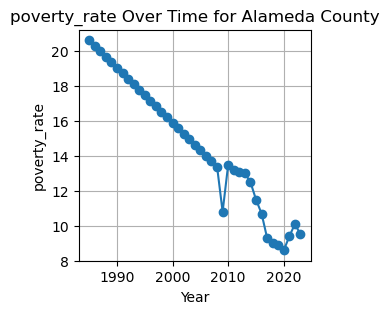

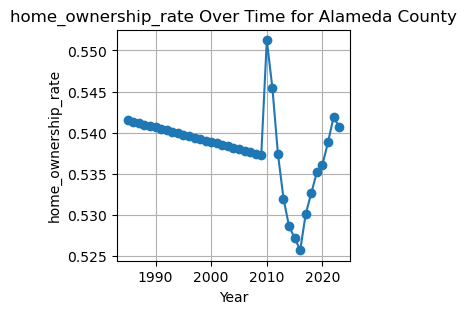

In [6]:
import matplotlib.pyplot as plt

# Filter data for Alameda county (the index for the first level is County)
df_alameda = df_reg_filled.loc['Alameda']

# Plot the adjusted_income column with Year on the x-axis
plt.figure(figsize=(3,3))
plt.plot(df_alameda.index, df_alameda['poverty_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('poverty_rate')
plt.title('poverty_rate Over Time for Alameda County')
plt.grid(True)
plt.show()

plt.figure(figsize=(3,3))
plt.plot(df_alameda.index, df_alameda['home_ownership_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('home_ownership_rate')
plt.title('home_ownership_rate Over Time for Alameda County')
plt.grid(True)
plt.show()

Seems like all the budgets are missing for San Fransisco??

In [7]:
for col in df_reg_filled.columns:
    XX=df_reg_filled[[col]].isna()
    XX=XX[XX[col]==True]
    if len(XX)>0:
        print(XX)

                    adj_police_budget
County        Year                   
San Francisco 1985               True
              1986               True
              1987               True
              1988               True
              1989               True
              1990               True
              1991               True
              1992               True
              1993               True
              1994               True
              1995               True
              1996               True
              1997               True
              1998               True
              1999               True
              2000               True
              2001               True
              2002               True
              2003               True
              2004               True
              2005               True
              2006               True
              2007               True
              2008               True
            

In [8]:
final_dataframe = df_reg_filled
final_dataframe=final_dataframe.dropna()
final_dataframe.columns

Index(['crime_rate', 'Population', 'clearance_rate', 'population_density',
       'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden',
       'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate',
       'renter_ratio', 'Number_of_Persons_per_HseHld', 'median_age',
       'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'social_vs_security',
       'security_vs_social', 'Category_Rural', 'Category_Suburban',
       'Category_Urban'],
      dtype='object')

In [9]:
Urban_df=final_dataframe[final_dataframe["Category_Urban"]==1]
Urban_df=Urban_df.drop(['Category_Rural', 'Category_Suburban',
       'Category_Urban'],axis=1)
Urban_df.head()

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   

              home_ownership_rate  mobile_home_ratio  ...  \
County  Year                                          ...   
Alameda 1985             0.541511           0.013777  ...   
        1986             0.541334           0.013726  ...   
        1987             0.541157           0.013674  ...   
        1988             0.540979           0.013623  ...   
        1989             0.540802           0.013572  ...   

              adj_mental_health_budget  adj_rehab_budget  adj_health_budget  \
County  Year                                                                  
Alameda 1985                  0.532488          0.000292           0.506076   
        1986                  0.541764          0.002939           0.546486   
        1987                  0.551040          0.005587           0.586896   
        1988                  0.560316          0.008235           0.627305   
        1989                  0.569592          0.010883           0.667715   

              adj_judiciary_budget  adj_prison_budget  house_affordability  \
County  Year                                                                 
Alameda 1985              0.607080           0.349449             6.598017   
        1986              0.603444           0.360553             6.625489   
        1987              0.599807           0.371658             6.652962   
        1988              0.596171           0.382763             6.680434   
        1989              0.592534           0.393867             6.707907   

              uninsured_rate  high_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985        0.359035         53.839341            2.132060   
        1986        0.350230         54.807253            2.135405   
        1987        0.341424         55.775165            2.138751   
        1988        0.332619         56.743077            2.142097   
        1989        0.323813         57.710989            2.145442   

              security_vs_social  
County  Year                      
Alameda 1985            0.394342  
        1986            0.396383  
        1987            0.398423  
        1988            0.400463  
        1989            0.402504  

[5 rows x 27 columns]

In [10]:
Subrban_df=final_dataframe[final_dataframe["Category_Suburban"]==1]
Suburban_df=Subrban_df.drop(['Category_Rural', 'Category_Suburban',
       'Category_Urban'],axis=1)
Suburban_df.head()

crime_rate  Population  clearance_rate  population_density  \
County Year                                                               
Butte  1985    0.003845      159700        0.400651           99.563591   
       1986    0.005178      163000        0.425355          101.620948   
       1987    0.004483      166200        0.440268          103.615960   
       1988    0.004362      170800        0.546309          106.483791   
       1989    0.004058      175200        0.555556          109.226933   

             unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County Year                                                                  
Butte  1985          10.588102       148.688655     27.770238    55.809890   
       1986          10.490709       149.908188     27.502381    55.648352   
       1987          10.393316       151.127720     27.234524    55.486813   
       1988          10.295922       152.347253     26.966667    55.325275   
       1989          10.198529       153.566786     26.698810    55.163736   

             home_ownership_rate  mobile_home_ratio  ...  \
County Year                                          ...   
Butte  1985             0.652191           0.193721  ...   
       1986             0.650298           0.191548  ...   
       1987             0.648404           0.189375  ...   
       1988             0.646511           0.187203  ...   
       1989             0.644618           0.185030  ...   

             adj_mental_health_budget  adj_rehab_budget  adj_health_budget  \
County Year                                                                  
Butte  1985                  0.484828         -0.099451           0.951137   
       1986                  0.497010         -0.092872           0.963070   
       1987                  0.509192         -0.086293           0.975003   
       1988                  0.521375         -0.079715           0.986935   
       1989                  0.533557         -0.073136           0.998868   

             adj_judiciary_budget  adj_prison_budget  house_affordability  \
County Year                                                                 
Butte  1985              0.317979           0.203980             6.436580   
       1986              0.322063           0.218446             6.406308   
       1987              0.326148           0.232911             6.376036   
       1988              0.330233           0.247377             6.345764   
       1989              0.334318           0.261843             6.315492   

             uninsured_rate  high_school_rate  social_vs_security  \
County Year                                                         
Butte  1985        0.439181         41.988791            4.563705   
       1986        0.428701         43.320440            4.500192   
       1987        0.418220         44.652088            4.436679   
       1988        0.407740         45.983736            4.373166   
       1989        0.397259         47.315385            4.309653   

             security_vs_social  
County Year                      
Butte  1985            0.100749  
       1986            0.110091  
       1987            0.119433  
       1988            0.128775  
       1989            0.138117  

[5 rows x 27 columns]

In [11]:
Rural_df=final_dataframe[final_dataframe["Category_Rural"]==1]
Rural_df=Rural_df.drop(['Category_Rural', 'Category_Suburban','Category_Urban'],axis=1)
Rural_df.head()

crime_rate  Population  clearance_rate  population_density  \
County Year                                                               
Alpine 1985    0.007273        1100        0.500000            1.488498   
       1986    0.020175        1140        0.565217            1.542625   
       1987    0.005310        1130        0.166667            1.529093   
       1988    0.001818        1100        0.000000            1.488498   
       1989    0.003670        1090        0.000000            1.474966   

             unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County Year                                                                  
Alpine 1985          12.405927       168.451199     23.575833   138.965934   
       1986          12.262545       170.113659     23.378333   135.574725   
       1987          12.119162       171.776119     23.180833   132.183516   
       1988          11.975780       173.438579     22.983333   128.792308   
       1989          11.832398       175.101040     22.785833   125.401099   

             home_ownership_rate  mobile_home_ratio  ...  \
County Year                                          ...   
Alpine 1985             0.702002           0.034287  ...   
       1986             0.705469           0.033737  ...   
       1987             0.708937           0.033188  ...   
       1988             0.712404           0.032639  ...   
       1989             0.715872           0.032089  ...   

             adj_mental_health_budget  adj_rehab_budget  adj_health_budget  \
County Year                                                                  
Alpine 1985                 -4.302015          2.531187          -0.872088   
       1986                 -4.012811          2.483112          -0.559609   
       1987                 -3.723607          2.435037          -0.247130   
       1988                 -3.434403          2.386962           0.065349   
       1989                 -3.145199          2.338887           0.377828   

             adj_judiciary_budget  adj_prison_budget  house_affordability  \
County Year                                                                 
Alpine 1985              0.054355           1.471840            14.787091   
       1986              0.095302           1.466273            14.525953   
       1987              0.136248           1.460705            14.264816   
       1988              0.177194           1.455138            14.003678   
       1989              0.218141           1.449571            13.742540   

             uninsured_rate  high_school_rate  social_vs_security  \
County Year                                                         
Alpine 1985        0.763539         50.465714            0.839945   
       1986        0.744174         51.645714            0.854444   
       1987        0.724809         52.825714            0.868944   
       1988        0.705445         54.005714            0.883443   
       1989        0.686080         55.185714            0.897942   

             security_vs_social  
County Year                      
Alpine 1985            1.044390  
       1986            1.036089  
       1987            1.027789  
       1988            1.019489  
       1989            1.011189  

[5 rows x 27 columns]

Correlations



Urban Correlation Matrix:


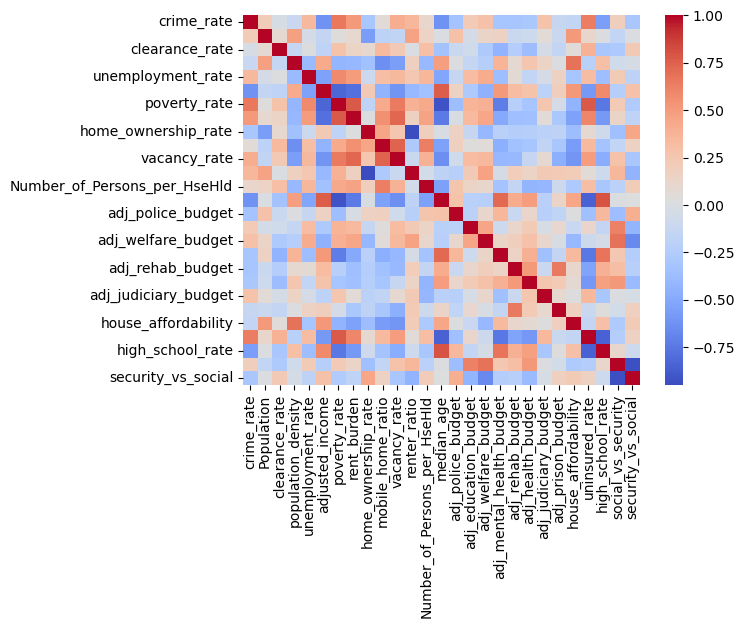



Suburban Correlation Matrix:


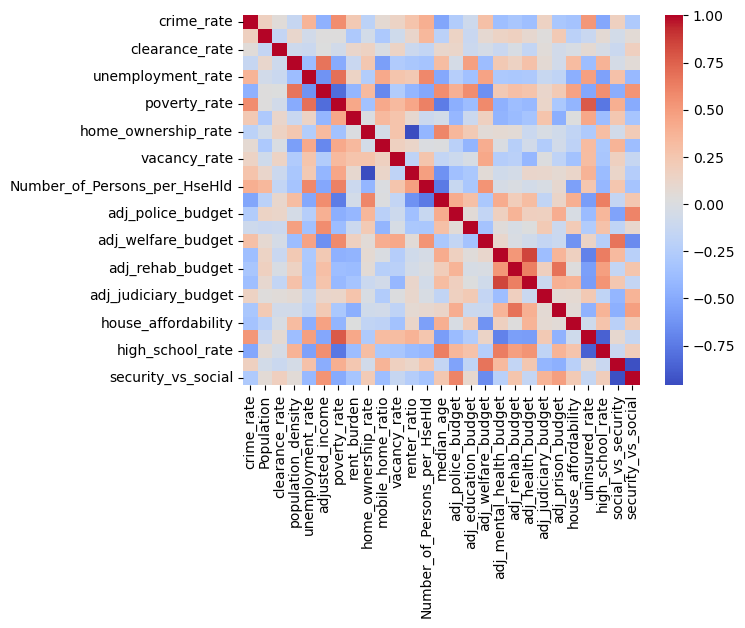



Rural Correlation Matrix:


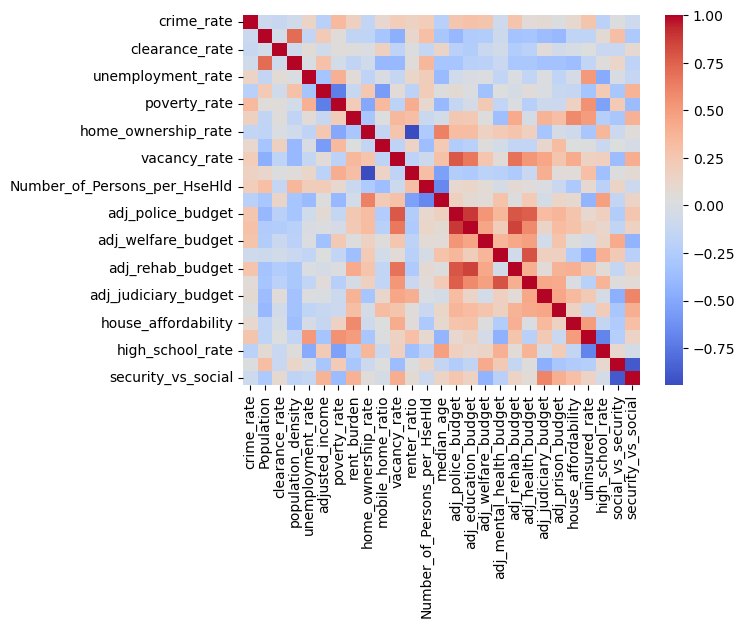

In [12]:
Urban_matrix = Urban_df.corr()
Suburban_matrix = Suburban_df.corr()
Rural_matrix = Rural_df.corr()

print("\n")
print("Urban Correlation Matrix:")
sns.heatmap(Urban_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()

print("\n")
print("Suburban Correlation Matrix:")
sns.heatmap(Suburban_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()

print("\n")
print("Rural Correlation Matrix:")
sns.heatmap(Rural_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.show()



Urban Correlation Matrix:


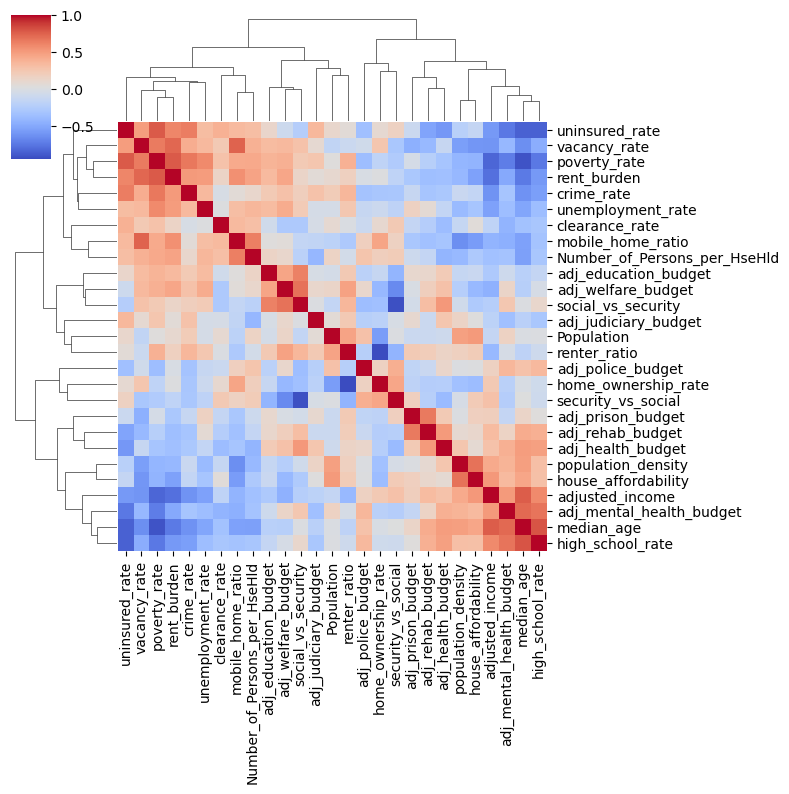



Suburban Correlation Matrix:


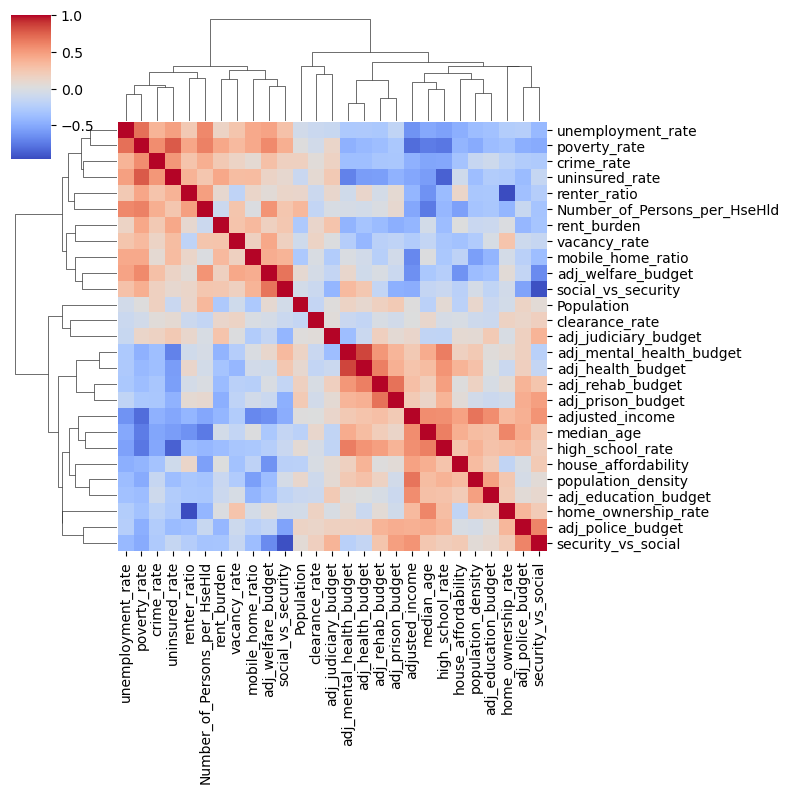



Rural Correlation Matrix:


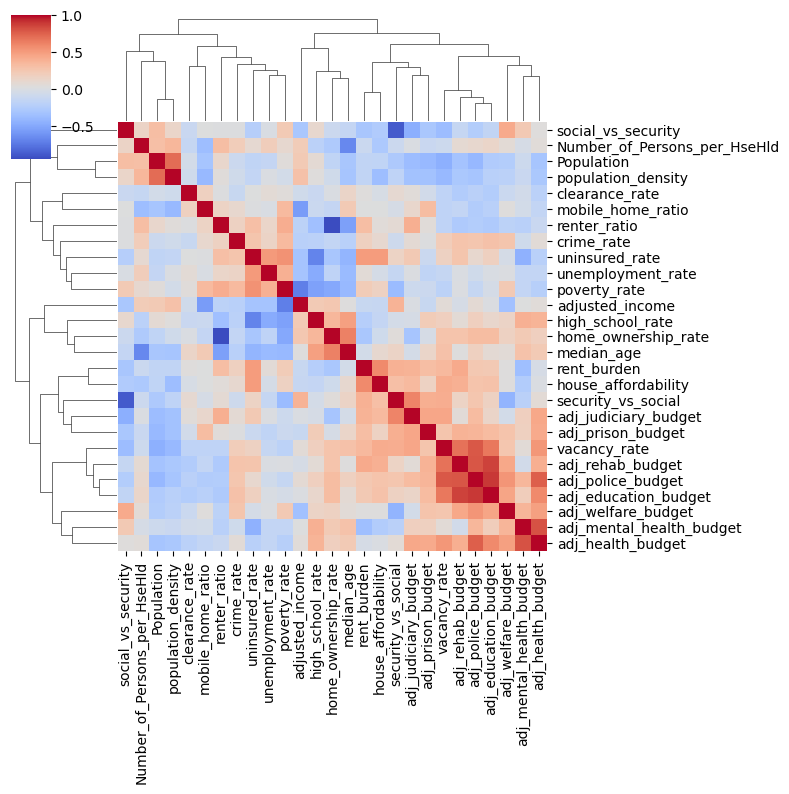

In [13]:
print("\n")
print("Urban Correlation Matrix:")
sns.clustermap(Urban_matrix, cmap="coolwarm", figsize=(8, 8))
plt.show()

print("\n")
print("Suburban Correlation Matrix:")
sns.clustermap(Suburban_matrix, cmap="coolwarm", figsize=(8, 8))
plt.show()

print("\n")
print("Rural Correlation Matrix:")
sns.clustermap(Rural_matrix, cmap="coolwarm", figsize=(8, 8))
plt.show()

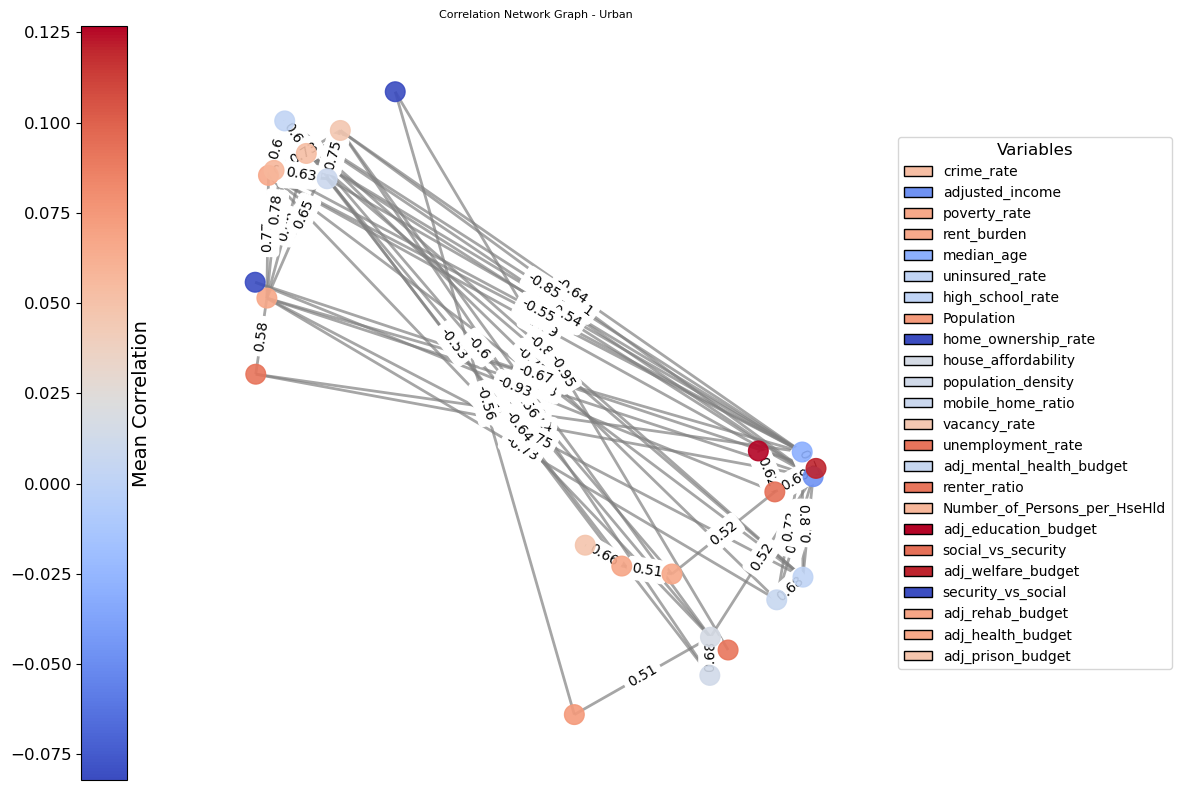

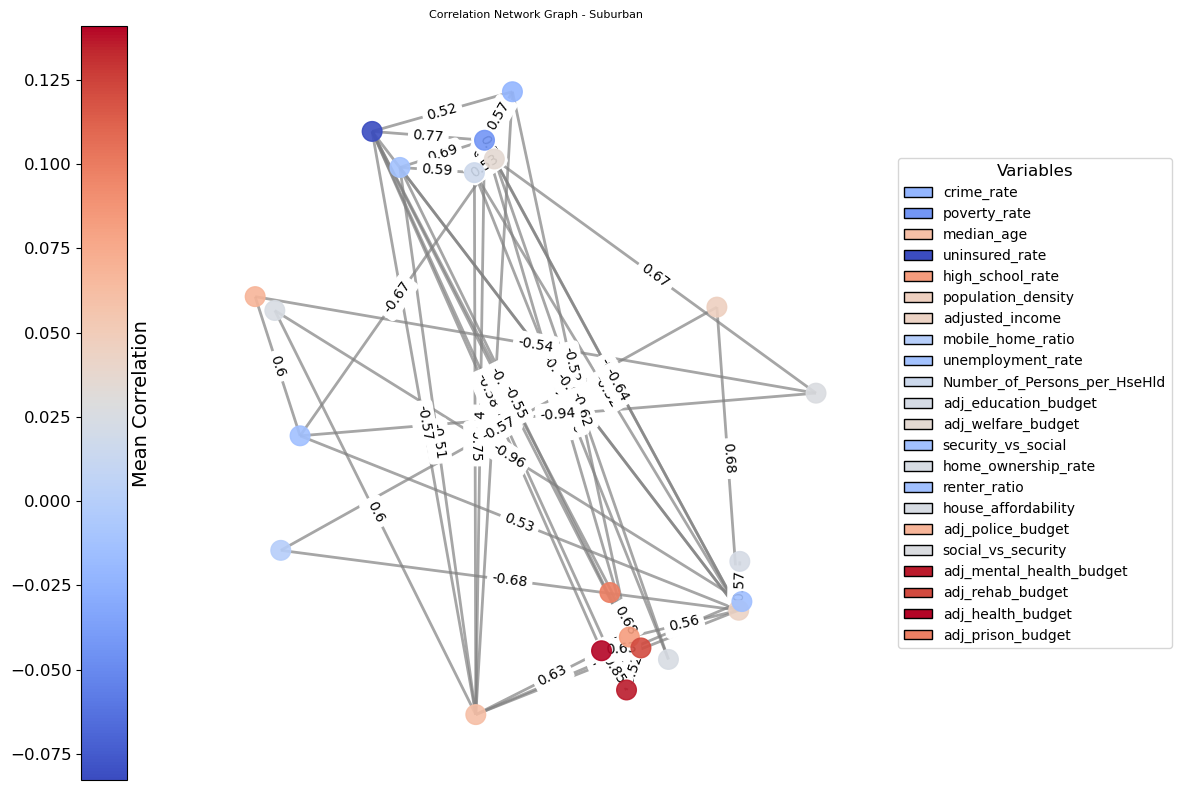

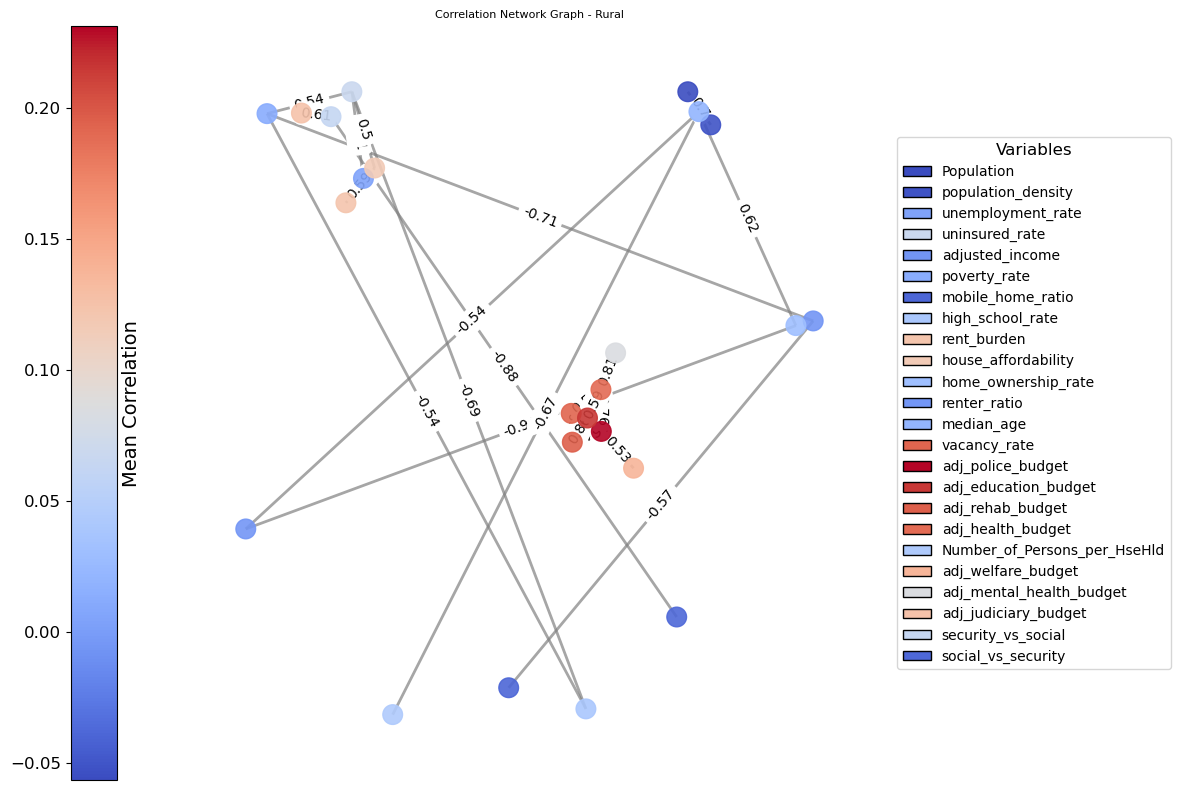

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

# Define the correlation threshold
threshold = 0.5

# Store your matrices in a dictionary for easy iteration
matrices = {
    'Urban': Urban_matrix,
    'Suburban': Suburban_matrix,
    'Rural': Rural_matrix
}

# Iterate over each matrix to create separate graphs
for label, correlation_matrix in matrices.items():
    
    # Ensure the matrix is square
    if not correlation_matrix.columns.equals(correlation_matrix.index):
        raise ValueError(f"The correlation matrix for {label} must have identical rows and columns.")
    
    # Create an empty graph
    G = nx.Graph()

    # Add nodes and weighted edges based on the threshold
    for i in correlation_matrix.columns:
        for j in correlation_matrix.index:
            if i != j and abs(correlation_matrix.at[i, j]) > threshold:
                G.add_edge(i, j, weight=correlation_matrix.loc[i, j])
    
    # Filter nodes to those present in the graph
    graph_nodes = list(G.nodes)
    
    # Compute the mean correlation for nodes present in G (using submatrix)
    node_colors = correlation_matrix.loc[graph_nodes, graph_nodes].mean(axis=0)
    norm = mcolors.Normalize(vmin=node_colors.min(), vmax=node_colors.max())
    cmap = plt.cm.coolwarm
    node_colors_mapped = [cmap(norm(value)) for value in node_colors]
    
    # Calculate the layout of nodes using a force-directed algorithm
    pos = nx.spring_layout(G, seed=42)
    
    # Create a figure with a custom grid layout (colorbar, main plot, and legend)
    fig = plt.figure(figsize=(12, 8))
    grid = fig.add_gridspec(1, 3, width_ratios=[0.05, 0.75, 0.2])
    ax_cbar = fig.add_subplot(grid[0])
    ax_main = fig.add_subplot(grid[1])
    ax_legend = fig.add_subplot(grid[2])
    
    # Draw the nodes, edges, and edge labels on the main axis
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors_mapped, alpha=0.9, ax=ax_main)
    nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", alpha=0.7, ax=ax_main)
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={(u, v): round(d["weight"], 2) for u, v, d in G.edges(data=True)},
        font_size=10,
        font_color="black",
        ax=ax_main,
    )
    ax_main.set_title(f"Correlation Network Graph - {label}", fontsize=8)
    ax_main.axis("off")
    
    # Add a vertical color bar indicating the mean correlation values
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=ax_cbar, orientation="vertical")
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("Mean Correlation", fontsize=14)
    ax_cbar.yaxis.tick_left()
    
    # Create a legend mapping node colors to variables
    ax_legend.axis("off")
    legend_elements = [
        Patch(facecolor=cmap(norm(value)), edgecolor="black", label=f"{node}")
        for node, value in zip(graph_nodes, node_colors)
    ]
    ax_legend.legend(
        handles=legend_elements,
        loc="center",
        title="Variables",
        fontsize=10,
        title_fontsize=12,
    )
    
    # Finalize the layout and display the plot for this matrix
    plt.tight_layout()
    plt.show()


Get test and train datasets

In [15]:
train_Urban, test_Urban = train_test_split(Urban_df, test_size=0.15, random_state=42)
train_Suburban, test_Suburban = train_test_split(Suburban_df, test_size=0.15, random_state=42)
train_Rural, test_Rural = train_test_split(Rural_df, test_size=0.15, random_state=42)

### Regression Analysis

Codes to help with regression analysis

In [16]:
# A function to fit models
def fit_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    **models
) -> tuple[dict, dict[dict,], dict[dict,]]:
    """
    Fit nodels an compute compute their root mean square errors,
    mean square errors and r2 socres

    Parameters:
    X_train(pd.DataFrame): features-train data
    X_test(pd.DataFrame): features-test data
    y_train(pd.DataFrame): target-train data
    y_test(pd.DataFrame): target-test data
    models: A dictionary of models

    Returns:
    dict: A tuple (dict, dict, dict).
    - First dict: The fitted models
    - Second dict: A dictionary of dictionaries.
        Each dictionary contains two lists [root mean square errors, mean square errors, r2 socres].
        One for train data and the other for test data.
    - Third dict: A dictionary of dictionaries.
        Each dictionary contains two predicted values.
        One for train data and the other for test data.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        model.fit(X_train, y_train)

        # Find the model predictions on the training set
        train_preds = model.predict(X_train)

        # Find the model predictions on the test set
        test_preds = model.predict(X_test)

        # Find the mse on the training set
        train_mse = mean_squared_error(y_train, train_preds)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        train_r2score = r2_score(y_train, train_preds)

        # Find the mse on the test set
        test_mse = mean_squared_error(y_test, test_preds)
        test_rmse = root_mean_squared_error(y_test, test_preds)
        test_r2score = r2_score(y_test, test_preds)

        fitted_models[key] = model
        model_stats[key] = {
            "train": [train_mse, train_rmse, train_r2score],
            "test": [test_mse, test_rmse, test_r2score],
        }
        predicted_values[key] = {"train": train_preds, "test": test_preds}

    return fitted_models, model_stats, predicted_values

In [24]:
# A function to fit models with cross-validation
def cross_fit_models(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    **models
) -> tuple[dict, dict[dict,], dict[dict,]]:
    """
    Fit nodels an compute compute their root mean square errors,
    mean square errors and r2 socres

    Parameters:
    X_train(pd.DataFrame): features-train data
    X_test(pd.DataFrame): features-test data
    y_train(pd.DataFrame): target-train data
    y_test(pd.DataFrame): target-test data
    models: A dictionary of models

    Returns:
    dict: A tuple (dict, dict, dict).
    - First dict: The fitted models
    - Second dict: A dictionary of dictionaries.
        Each dictionary contains two lists [root mean square errors, mean square errors, r2 socres].
        One for train data and the other for test data.
    - Third dict: A dictionary of dictionaries.
        Each dictionary contains two predicted values.
        One for train data and the other for test data.
    """

    model_stats = {}
    fitted_models = {}
    predicted_values = {}

    for key, model in models.items():
        # Fit the models to the training data
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        train_mse = []
        train_rmse = []
        train_r2score = []
        test_mse = []
        test_rmse = []
        test_r2score = []
        for train_index, val_index in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            model.fit(X_tt, y_tt)
            # Find the model predictions on the training set
            train_preds = model.predict(X_tt)

            # Find the model predictions on the test set
            test_preds = model.predict(X_val)

            # Find the mse on the training set
            train_mse.append( mean_squared_error(y_tt, train_preds))
            train_rmse.append( root_mean_squared_error(y_tt, train_preds))
            train_r2score.append( r2_score(y_tt, train_preds))

            # Find the mse on the test set
            test_mse.append( mean_squared_error(y_val, test_preds))
            test_rmse.append( root_mean_squared_error(y_val, test_preds))
            test_r2score.append( r2_score(y_val, test_preds))

        model.fit(X_train, y_train)
        fitted_models[key] = model
        model_stats[key] = {
            "train": [np.mean(train_mse), np.mean(train_rmse), np.mean(train_r2score)],
            "test": [np.mean(test_mse), np.mean(test_rmse), np.mean(test_r2score)],
        }
        

    return fitted_models, model_stats

In [25]:
def optimal_subset(ss, X_train, y_train):
    ll=list(ss)
    #if len(ll)%10==0:
        #print("len is",len(ll))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    R2_val_scores = []
    XX=X_train[ll]
    for train_index, val_index in kf.split(X_train):
        lin_model = LinearRegression()
        X_tt, X_val = XX.iloc[train_index], XX.iloc[val_index]
        y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        lin_model.fit(X_tt, y_tt)
        y_pred = lin_model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        R2_val_scores.append(r2)
    r_initial=np.mean(R2_val_scores)
    if len(ss)==1:
        if r_initial>0:
            return set(ss)
        else:
            return set()

    for xx in ll:
        ss.remove(xx)
        R2_val_scores = []
        l1=list(ss)
        XX=X_train[l1]
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X_train):
            lin_model = LinearRegression()
            X_tt, X_val = XX.iloc[train_index], XX.iloc[val_index]
            y_tt, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
            lin_model.fit(X_tt, y_tt)
            y_pred = lin_model.predict(X_val)
            r2 = r2_score(y_val, y_pred)
            R2_val_scores.append(r2)
        r_now=np.mean(R2_val_scores)
        if r_now>r_initial:
            return optimal_subset(ss,X_train, y_train)
        ss.add(xx)
    return set(ss)

In [30]:
def print_table(model_stats):
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score"]

    for key, stat in model_stats.items():
        table.add_rows(
            [
                [key, "train data", stat["train"][0], stat["train"][1], stat["train"][2]],
                ["", "test data", stat["test"][0], stat["test"][1], stat["test"][2]],
            ],
            divider=True,
        )
    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)

In [27]:
def feature_importance(fitted_models,features,size):
    coeffs_mlr = fitted_models["mlr"].named_steps["Lin"].coef_
    sorted_indices_mlr = np.argsort(coeffs_mlr)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_mlr], coeffs_mlr[sorted_indices_mlr])
    plt.title("Linear Regression Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_mlr[i]),features[i]) for i in sorted_indices_mlr]
    ll.sort(reverse=True)
    print('The top 4 important features in mlr is')
    for xx in ll[:4]:
        print(xx[1])

    coeffs_ridge = fitted_models["ridge"].named_steps['ridge'].coef_
    sorted_indices_ridge = np.argsort(coeffs_ridge)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_ridge], coeffs_ridge[sorted_indices_ridge])
    plt.title("Ridge Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(coeffs_ridge[i]),features[i]) for i in sorted_indices_ridge]
    ll.sort(reverse=True)
    print('The top 4 important features in ridge is')
    for xx in ll[:4]:
        print(xx[1])

    importance_xgb = fitted_models["xgb"].feature_importances_
    sorted_indices_xgb = np.argsort(importance_xgb)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
    plt.title("XGB Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_xgb[i]),features[i]) for i in sorted_indices_xgb]
    ll.sort(reverse=True)
    print('The top 4 important features in xgb is')
    for xx in ll[:4]:
        print(xx[1])


    importance_randomforest = fitted_models["random_forest"].named_steps["randomforest"].feature_importances_
    sorted_indices_randomforest = np.argsort(importance_randomforest)
    plt.figure(figsize=size)
    plt.barh([features[i] for i in sorted_indices_randomforest], importance_randomforest[sorted_indices_randomforest])
    plt.title("RandomForest Coefficient Infulence")
    plt.xlabel("Coefficients")
    plt.show()

    ll=[(abs(importance_randomforest[i]),features[i]) for i in sorted_indices_randomforest]
    ll.sort(reverse=True)
    print('The top 4 important features in randomforest is')
    for xx in ll[:4]:
        print(xx[1])

In [37]:
def Poly_df_function(df0):
    poly=PolynomialFeatures(degree=2,include_bias=False)
    Poly_data=poly.fit_transform(df0)
    feature_names=poly.get_feature_names_out(input_features=df0.columns)
    Poly_df=pd.DataFrame(Poly_data,columns=feature_names)
    return Poly_df

def optimal_Poly_subset(Poly_df, y_train):
    ll=list(Poly_df.columns)
    N=len(ll)
    #print("start with ",N," features")
    S0=set()
    for i in range(0,N,10):
        S0=S0.union(set(ll[i:i+10]))
        S1=optimal_subset(S0,Poly_df,y_train)
        S0=S1
        #if i%50==0:
            #print(i,len(S0))
    return S0

Urban models

In [38]:
# Regression models to train
print("Urban models")

Xtrain_Urban = train_Urban[feature_0]
ytrain_Urban = train_Urban['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_urban0, models_stats_urban0 = cross_fit_models(
    Xtrain_Urban[feature_0], ytrain_Urban, **models
)

# Using pretty table
print_table(models_stats_urban0)

#feature_importance(fitted_models_urban0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Urban_features=list(optimal_subset(set(feature_0), Xtrain_Urban, ytrain_Urban))
print(len(Urban_features),Urban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_urban, models_stats_urban = cross_fit_models(
    Xtrain_Urban[Urban_features], ytrain_Urban, **models
)

# Using pretty table
print_table(models_stats_urban)

#feature_importance(fitted_models_urban, Urban_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Urban[feature_0])
Urban_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Urban))
print(len(Urban_Poly_features),Urban_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_urban, Poly_models_stats_urban = cross_fit_models(
    Poly_df[Urban_Poly_features], ytrain_Urban, **models
)

# Using pretty table
print_table(Poly_models_stats_urban)

#feature_importance(fitted_Poly_models_urban, Urban_Poly_features, (4, 4))



Urban models

feature 0
26 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'renter_ratio', 'Number_of_Persons_per_HseHld', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦════════════════════════╦════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE          ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 2.1428928273597516e-06 ║ 0.0014634813864877042  ║ 0.7441702424075094 ║
║               ║ test data  ║ 

In [40]:
# Regression models to train
print("Suburban models")

Xtrain_Suburban = train_Suburban[feature_0]
ytrain_Suburban = train_Suburban['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_Suburban0, models_stats_Suburban0 = cross_fit_models(
    Xtrain_Suburban[feature_0], ytrain_Suburban, **models
)

# Using pretty table
print_table(models_stats_Suburban0)

#feature_importance(fitted_models_Suburban0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Suburban_features=list(optimal_subset(set(feature_0), Xtrain_Suburban, ytrain_Suburban))
print(len(Suburban_features),Suburban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_Suburban, models_stats_Suburban = cross_fit_models(
    Xtrain_Suburban[Suburban_features], ytrain_Suburban, **models
)

# Using pretty table
print_table(models_stats_Suburban)

#feature_importance(fitted_models_Suburban, Suburban_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Suburban[feature_0])
Suburban_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Suburban))

print(len(Suburban_Poly_features),Suburban_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_Suburban, Poly_models_stats_Suburban = cross_fit_models(
    Poly_df[Suburban_Poly_features], ytrain_Suburban, **models
)

# Using pretty table
print_table(Poly_models_stats_Suburban)

#feature_importance(fitted_Poly_models_Suburban, Suburban_Poly_features, (4, 4))



Suburban models

feature 0
26 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'renter_ratio', 'Number_of_Persons_per_HseHld', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦════════════════════════╦════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE          ║      r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬════════════════════════╬════════════════════╣
║      mlr      ║ train data ║ 1.2693602125047615e-06 ║ 0.0011264787247241667  ║ 0.5980403203680705 ║
║               ║ test data 

In [43]:
# Regression models to train
print("Rural models")

Xtrain_Rural = train_Rural[feature_0]
ytrain_Rural = train_Rural['crime_rate']

print("\nfeature 0")
print(len(feature_0),feature_0)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

fitted_models_Rural0, models_stats_Rural0 = cross_fit_models(
    Xtrain_Rural[feature_0], ytrain_Rural, **models
)

# Using pretty table
print_table(models_stats_Rural0)

#feature_importance(fitted_models_Rural0, feature_0, (4, 4))


print("\noptimal subset of feature 0")
Rural_features=list(optimal_subset(set(feature_0), Xtrain_Rural, ytrain_Rural))
print(len(Urban_features),Urban_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_models_Rural, models_stats_Rural = cross_fit_models(
    Xtrain_Rural[Rural_features], ytrain_Rural, **models
)

# Using pretty table
print_table(models_stats_Rural)

#feature_importance(fitted_models_Rural, Rural_features, (4, 4))

#Include interaction terms in the model

print("\n include optimal subset of interaction terms")
Poly_df=Poly_df_function(Xtrain_Rural[feature_0])
Rural_Poly_features=list(optimal_Poly_subset(Poly_df, ytrain_Rural))
print(len(Rural_Poly_features),Rural_Poly_features)
models = {
    "mlr": Pipeline([("scale", StandardScaler()), ("Lin", LinearRegression())]),
    "xgb": xgb.XGBRegressor(random_state=42),
    "ridge": Pipeline([("scale", StandardScaler()), ("ridge", Ridge())]),
    "random_forest": Pipeline(
        [("scale", StandardScaler()), ("randomforest", RandomForestRegressor())]
    ),
}

# Get return values from the function fit_models
fitted_Poly_models_Rural, Poly_models_stats_Rural = cross_fit_models(
    Poly_df[Rural_Poly_features], ytrain_Rural, **models
)

# Using pretty table
print_table(Poly_models_stats_Rural)

#feature_importance(fitted_Poly_models_Rural, Rural_Poly_features, (4, 4))



Rural models

feature 0
26 ['Population', 'clearance_rate', 'population_density', 'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden', 'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate', 'renter_ratio', 'Number_of_Persons_per_HseHld', 'median_age', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'social_vs_security', 'security_vs_social']
╔═══════════════╦════════════╦════════════════════════╦═══════════════════════╦═════════════════════╗
║     Model     ║    Type    ║          MSE           ║          RMSE         ║       r2 Score      ║
╠═══════════════╬════════════╬════════════════════════╬═══════════════════════╬═════════════════════╣
║      mlr      ║ train data ║ 4.792215757290143e-06  ║ 0.0021885187723835395 ║  0.3472871924260935 ║
║               ║ test data  ║ 